In [1]:
#@title Setup

#%load_ext autoreload
#%autoreload 2

import os
import sys

import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex pytorch-ignite visdom


CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install --upgrade git+https://github.com/nielsrolf/siren-pytorch
!pip install --upgrade git+https://github.com/pollinations/AudioCLIP
!pip install --upgrade git+https://github.com/pollinations/CLIPTranslate

!wget https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt

!wget https://raw.githubusercontent.com/pollinations/CLIPTranslate/main/notebooks/data/cat.jpg
!wget https://raw.githubusercontent.com/pollinations/CLIPTranslate/main/notebooks/data/gt_bach.wav
!wget https://raw.githubusercontent.com/pollinations/CLIPTranslate/main/notebooks/data/hearbeat.jpg



  Cloning https://github.com/nielsrolf/siren-pytorch to /tmp/pip-req-build-9069wg4i
  Running command git clone -q https://github.com/nielsrolf/siren-pytorch /tmp/pip-req-build-9069wg4i
  Created wheel for siren-pytorch: filename=siren_pytorch-0.1.5-cp37-none-any.whl size=4171 sha256=69daeba4a68be48a595b24ae06644ff662d3bb0c6a703ebdf5f05eea050a70d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-fifk8vrd/wheels/e8/83/8d/5c4db6b96d293d233992048f3679d7342030d381893b87b1e9
Successfully built siren-pytorch
  Found existing installation: siren-pytorch 0.1.5
    Uninstalling siren-pytorch-0.1.5:
      Successfully uninstalled siren-pytorch-0.1.5
  Cloning https://github.com/pollinations/AudioCLIP to /tmp/pip-req-build-ltimn3w9
  Running command git clone -q https://github.com/pollinations/AudioCLIP /tmp/pip-req-build-ltimn3w9
  Created wheel for AudioCLIP: filename=AudioCLIP-0.0.1-cp37-none-any.whl size=40072 sha256=76c61bddda945a9fb635ef5bbd76969cf4a93959fc02aa517c086c793f46c2d4
  Stored i

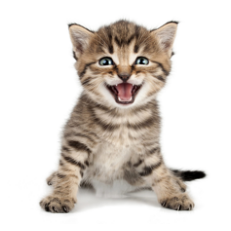

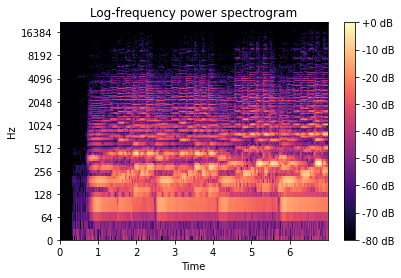

In [3]:

from clip_translate.utils import load_img, imshow, load_audio, play
sample_img = load_img("/content/cat.jpg")
imshow(sample_img)

sample_audio = load_audio("/content/gt_bach.wav")
play(sample_audio)

from torch.autograd import Variable
from siren_pytorch import SirenNet, SirenWrapperNDim
import time
from IPython.display import clear_output
from clip_translate import AudioImagine, sample_rate
import torch

DEVICE = torch.device('cuda:0')

rate=sample_rate

# Fit an audio to a text or image prompt

step 16250 tensor(-42.7748)


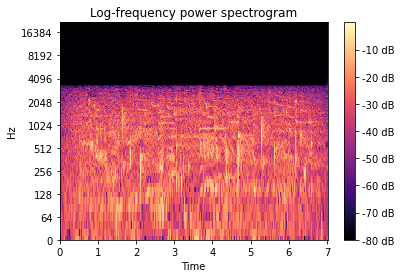

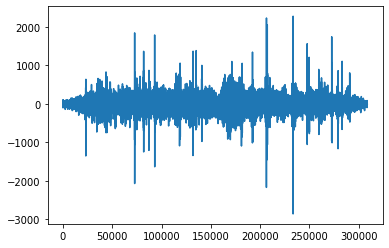

In [ ]:
from clip_translate import AudioImagine, get_audio_siren, fit_siren
from audioclip import AudioCLIP
import matplotlib.pyplot as plt 
import os
import sys
!git clone https://github.com/boschresearch/multiplicative-filter-networks
sys.path.append("./multiplicative-filter-networks/mfn")

from mfn import FourierNet, GaborNet


imagine = AudioImagine(
    perceptor="AudioCLIP-Full-Training.pt", 
   # text="cat", 
    image=sample_img
    )


steps_till_summary = 200

def get_model_input(seconds):
  return torch.linspace(-1.0, 1.0, round(seconds*rate), device='cuda').reshape([ 1,-1, 1]).to("cuda")

coords = get_model_input(7)
audio_frames=coords.shape[1]

model = FourierNet(
        in_size=1,
        hidden_size=512,
        out_size=1,
        n_layers=3,
        input_scale=audio_frames/8,
        weight_scale=1,
    ).to("cuda")

optim = torch.optim.Adam(lr=0.001, params=model.parameters())

print("cooords",coords, coords.dtype)
steps = 1000000
steps_till_summary = 50
for step in range(steps):
    model_output = model(coords).reshape((1,1,-1))# siren(coords).reshape((1,1,-1)) 
    #print(model_output.shape)
    #_,loss = perceptor(audio=model_output, text=[["bla"]])

    loss = -100 * imagine.get_score(model_output, augment=True)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % steps_till_summary == 0:
        clear_output()
        print("step",step,loss.cpu().detach())
        pred_audio = model_output
        play(pred_audio)
        plt.plot(pred_audio.cpu().detach().numpy().squeeze())
        plt.show()
#fit_siren(imagine, siren,  steps=1000, augment=False)

# Fitting a hypernetwork

In [ ]:
import torch.nn.functional as F
from torch import nn
from clip_translate import AudioImagine, get_siren_decoder, fit_siren
from matplotlib import pyplot as plt

class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder, loss):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.loss = loss
  
  def forward(self, audio, target=None):
    latent = self.encoder(audio)
    reconstructed = self.decoder(latent=latent)
    if target is not None:
      return self.loss(target, reconstructed)
    return reconstructed


latent = nn.Parameter(torch.zeros(1024).normal_(0, 1)).to('cuda')
def constant_encoder(audio):
  return latent


def clip_encoder(audio):
  audio = audio.reshape(1, -1)
  with torch.no_grad():
    latent = imagine.encode_audio(audio.detach())
  return latent.reshape(1024)


def get_siren_decoder(output_shape, latent_dim=1024):
    net = SirenNet(
        dim_in=1,
        dim_hidden=256,
        dim_out=1,
        num_layers=3,
        w0=30.,
        w0_initial=10000.,
        use_bias=True,
        final_activation=None)

    decoder = SirenWrapperNDim(
        net,
        latent_dim=latent_dim,
        output_shape=output_shape
    )
    decoder.cuda()

    return decoder



def train_on_single_sample(ae, lr=1e-4, steps=2000):
  optim = torch.optim.Adam(lr=lr, params=ae.parameters())
  steps_till_summary = 1000
  for step in range(steps):
    loss = ae(sample_audio, sample_audio)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % steps_till_summary == 0:
      print(loss.cpu().detach())
      pred_audio = ae(sample_audio)
      play(pred_audio)
      plt.plot(pred_audio.cpu().detach().numpy().squeeze())
      plt.show()

# decoder = get_siren_decoder(sample_audio.shape, 1024)
# ae = Autoencoder(encoder=clip_encoder, decoder=decoder, loss=F.mse_loss)
# train_on_single_sample(ae)

In [ ]:
class GON(Autoencoder):
    def __init__(self, decoder):
        super().__init__(encoder=self.encode, decoder=decoder, loss=F.mse_loss)
    
    def encode(self, audio):
        latent = nn.Parameter(torch.zeros(1024)).to('cuda')
        inner_loss = self.loss(audio, self.decoder(latent=latent))
        z = -torch.autograd.grad(inner_loss, [latent], create_graph=True, retain_graph=True)[0]
        return z

decoder = get_siren_decoder(sample_audio.shape, 1024)
ae = GON(decoder=decoder)
train_on_single_sample(ae)

In [ ]:
# Train GON on multiple audio examples

from glob import glob


audio_files = glob("/content/drive/MyDrive/ddsp/samples/*/*.wav")
audio_files

In [ ]:
audios = [load_audio(i) for i in audio_files]



In [ ]:
audios[0].shape

In [ ]:
import numpy as np

def random_crop(audio, seconds=4):
    audio_shape = audio.shape
    frames = int(seconds * rate)
    cutoff = audio.shape[0] - frames
    cutoff_start = np.random.randint(0, cutoff)
    cutoff_end = cutoff - cutoff_start
    audio = audio[cutoff_start:-cutoff_end]
    return audio

def get_sample():
    audio = audios[np.random.randint(len(audios))]
    return random_crop(audio, seconds=4)


for _ in range(4):
    play(get_sample())

In [ ]:
steps = 10000
lr = 1e-3





decoder = get_siren_decoder(get_sample().shape, 1024)
ae = GON(decoder=decoder)

optim = torch.optim.Adam(lr=lr, params=ae.parameters())
steps_till_summary = 1000
for step in range(steps):
    x = get_sample()
    loss = ae(x, x)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % steps_till_summary == 0:
        print(loss.cpu().detach())
        pred_audio = ae(x)
        play(pred_audio)
        plt.plot(pred_audio.cpu().detach().numpy().squeeze())
        plt.show()